In [2]:
import os
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten

# Other imports
import datetime
import scipy
import itertools

# Ensure that warnings are not shown
import warnings
warnings.filterwarnings("ignore")

# Your code here...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from skimage.io import imread
from skimage.transform import resize
imageSize=128
train_dir = "/content/drive/MyDrive/Foot_Ulcer/Train"
test_dir =  "/content/drive/MyDrive/Foot_Ulcer/Test"
# ['Covid19', 'Normal', 'Opacity', 'Pneumonia']
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):

            if folderName in ['MAL']:
                label = 0
            elif folderName in ['BEN']:
                label = 1
                '''
            elif folderName in ['Opacity']:
                label = 2
            elif folderName in ['pneumonia']:
                label = 3
                '''
            else:
                label = 4

            for image_filename in tqdm(os.listdir(folder + '/'+folderName)):


                img_file = cv2.imread(folder + '/'+folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)

                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)

    return X,y
X_train, y_train = get_data(train_dir) # Un-comment to use full dataset: Step 1 of 2
X_test, y_test= get_data(test_dir)


100%|██████████| 100/100 [00:01<00:00, 63.91it/s]


In [7]:
# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [13]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D
num_classes = 2
model = AlexNet((imageSize, imageSize, 3), num_classes)

In [14]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [15]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)
model.summary()

Model: "alex_net_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 96)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)         885120    
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 384)         1

In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory("/content/drive/MyDrive/Foot_Ulcer/Train",
                                                 target_size = (imageSize, imageSize),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory("/content/drive/MyDrive/Foot_Ulcer/Test",
                                            target_size = (imageSize, imageSize),
                                            batch_size =8,
                                            class_mode = 'categorical')

Found 1024 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [19]:
epochs=25

In [20]:
history = model.fit(
  training_set,
  validation_data=test_set,
  epochs=epochs,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/25
64/64 [==============================] - 9s 133ms/step - loss: 0.6698 - tp: 605.0000 - fp: 419.0000 - tn: 605.0000 - fn: 419.0000 - accuracy: 0.5908 - precision: 0.5908 - recall: 0.5908 - auc: 0.6449 - val_loss: 0.6954 - val_tp: 100.0000 - val_fp: 100.0000 - val_tn: 100.0000 - val_fn: 100.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5512
Epoch 2/25
64/64 [==============================] - 8s 117ms/step - loss: 0.7232 - tp: 704.0000 - fp: 320.0000 - tn: 704.0000 - fn: 320.0000 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.7667 - val_loss: 0.4462 - val_tp: 156.0000 - val_fp: 44.0000 - val_tn: 156.0000 - val_fn: 44.0000 - val_accuracy: 0.7800 - val_precision: 0.7800 - val_recall: 0.7800 - val_auc: 0.8735
Epoch 3/25
64/64 [==============================] - 10s 155ms/step - loss: 0.8133 - tp: 577.0000 - fp: 447.0000 - tn: 577.0000 - fn: 447.0000 - accuracy: 0.5635 - precision: 0.5635 - recall: 0.5635 - auc: 0.6045 - val_

In [21]:
# Evaluate model
score = model.evaluate(test_set,verbose=0)
print('\nKeras CNN - accuracy:', score[5], '\n')


Keras CNN - accuracy: 0.5 



In [22]:
model.save("alexnet.h5")

In [23]:
score

[0.693217933177948, 100.0, 100.0, 100.0, 100.0, 0.5, 0.5, 0.5, 0.5]

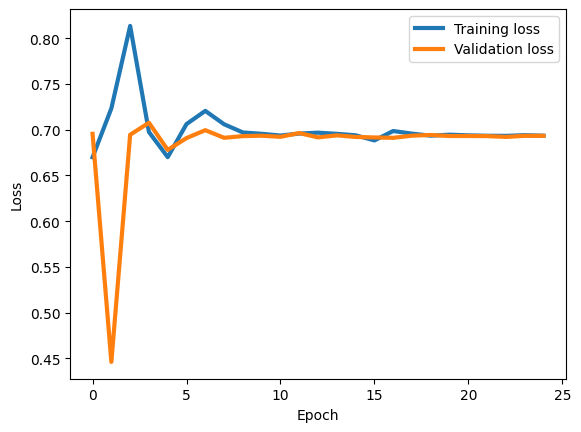

<Figure size 640x480 with 0 Axes>

In [24]:
# plot the loss
plt.plot(history.history['loss'], label='Training loss', linewidth=3)
plt.plot(history.history['val_loss'], label='Validation loss', linewidth=3)
plt.xlabel('Epoch'); plt.ylabel('Loss');
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

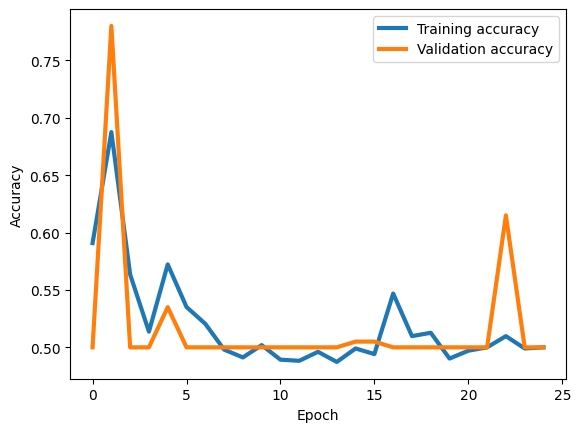

<Figure size 640x480 with 0 Axes>

In [26]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='Training accuracy', linewidth=3)
plt.plot(history.history['val_accuracy'], label='Validation accuracy', linewidth=3)
plt.xlabel('Epoch'); plt.ylabel('Accuracy');
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [27]:
Y_pred=model.predict(test_set)
y_pred=np.argmax(Y_pred,axis=1)

25/25 [==============================] - 1s 26ms/step


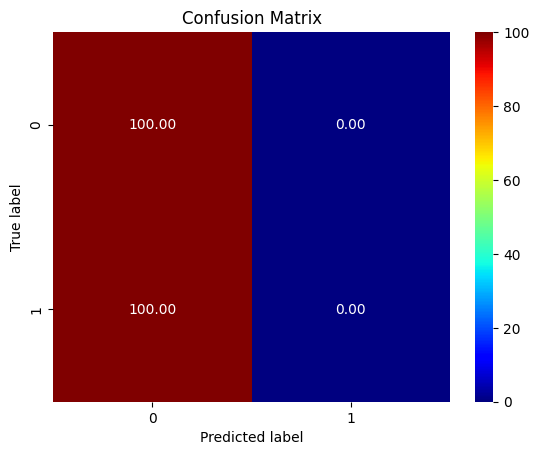

In [28]:
cm=confusion_matrix(test_set.classes,y_pred)
f = sns.heatmap(cm, annot=True, fmt='.2f',cmap='jet')
f.set_xlabel('Predicted label');f.set_ylabel('True label');
f.set_title('Confusion Matrix');

In [29]:
# Extracting Intermediate Layers Output

In [30]:
from keras.models import Model

In [31]:
model.summary()

Model: "alex_net_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 96)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)         885120    
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 384)         1